In [ ]:
!pip install Arabic-Stopwords
!pip install openpyxl
#used for reading and writing Excel 2010
!pip install ktrain
#It simplifies tasks related to training and deploying machine learning models

In [ ]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
!pip install datasets
# Import functions for data preprocessing & data preparation
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer

import arabicstopwords.arabicstopwords as stp
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from string import punctuation
import nltk
import re

from datasets import load_dataset

nltk.download('punkt')
nltk.download('stopwords')

ds = load_dataset("arbml/SANAD")

print("Dataset Structure:")
ds

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split: 0 examples [00:00, ? examples/s]

Dataset Structure:


DatasetDict({
    train: Dataset({
        features: ['Article', 'label'],
        num_rows: 141807
    })
})

In [ ]:
# Inspect the 'train' split if available
if 'train' in ds:
    train_dataset = ds['train']
    print("\nColumns in 'train' split:")
    print(train_dataset.column_names)

    # Convert the 'train' dataset to a DataFrame
    df = train_dataset.to_pandas()

    print("\nFirst few rows of the 'train' dataset:")
    print(df.head())


Columns in 'train' split:
['Article', 'label']

First few rows of the 'train' dataset:
                                             Article  label
0  يحيي كل من العروسي وعواطف وعمار والعنبري أمجاد...      5
1  أخبارنا المغربية ـ هدى جميعي\nتحول فنان مغربي ...      5
2  بالفيديو : الفنان الشعبي العمري يتهم الداودي و...      5
3  عبدالاله بوسحابة : اخبارنا المغربية\nعلمنا في ...      5
4  أخبارنا المغربية : حنان سلامة\nكعادته كلما تعل...      5


In [ ]:
import re
import string
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from nltk.corpus import stopwords

stop_words = stopwords.words('arabic')
tok = WordPunctTokenizer()

def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def unified_preprocessing(text):
    # Normalize Arabic text
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    # Remove diacritics
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', text)

    # Remove punctuations
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    text = text.translate(translator)

    # Remove repeating characters
    text = re.sub(r'(.)\1+', r'\1\1', text)

    # Remove non-Arabic letters and URLs
    text = re.sub(r'([@A-Za-z0-9_]+)|#|http\S+', ' ', text)
    text = re.sub(r'ـــــــــــــ', '', text)

    # Remove HTML tags
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()

    # Remove mentions and URLs
    pat1 = r'@[A-Za-z0-9]+'
    pat2 = r'https?://[A-Za-z0-9./]+'
    combined_pat = r'|'.join((pat1, pat2))
    stripped = re.sub(combined_pat, '', souped)

    # Remove emojis
    text = remove_emojis(stripped)

    # Tokenize and remove extra spaces
    words = tok.tokenize(text)
    return (" ".join(words)).strip()

# Apply unified preprocessing to the 'Article' column
df['Article'] = df['Article'].apply(lambda text: unified_preprocessing(str(text)))

# Label encoding for the 'label' column
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Display the DataFrame
df.head()


,Article,label
0,يحيي كل من العروسي وعواطف وعمار والعنبري امجاد...,5
1,اخبارنا المغربيه هدي جميعي تحول فنان مغربي مغم...,5
2,بالفيديو الفنان الشعبي العمري يتهم الداودي و ا...,5
3,عبدالاله بوسحابه اخبارنا المغربيه علمنا في موق...,5
4,اخبارنا المغربيه حنان سلامه كعادته كلما تعلق ا...,5


In [ ]:
num_rows = df.shape[0]
num_columns = df.shape[1]

print(f"The dataset contains {num_rows} rows and {num_columns} columns.")

The dataset contains 141807 rows and 2 columns.


In [ ]:
import pandas as pd

# Define the number of samples you want per label
samples_per_label = 6000

# Group by label and take the first `samples_per_label` rows for each label
df_filtered = df.groupby('label').apply(lambda x: x.head(samples_per_label)).reset_index(drop=True)

# Display the filtered DataFrame
print(df_filtered['label'].value_counts())

# Display the filtered DataFrame
df_filtered.head()

label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
Name: count, dtype: int64


,Article,label
0,للعام الثاني علي التوالي حصلت شركه اس تي اس ال...,0
1,اطلقت خدمه التراسل الفوري واتساب اليوم الجمعه ...,0
2,حصلت شركه سامسونغ علي حق براءه اختراع جديده لا...,0
3,ظهر تطبيق جديد للاجهزه الذكيه التي تعمل بنظام ...,0
4,اشارت بوابه الاتصالات الالمانيه هايزهدي الي رف...,0


In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, GRU, Dense, Bidirectional, Dropout, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd

MAX_NB_WORDS = 13000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_filtered['Article'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_final = tokenizer.texts_to_sequences(df_filtered['Article'].values)
X_final = pad_sequences(X_final, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_final.shape)

Y_final = pd.get_dummies(df_filtered['label']).values
print('Shape of label tensor:', Y_final.shape)

X_train, X_test, y_train, y_test = train_test_split(X_final, Y_final, test_size=0.33, random_state=42)
print('Training data shape:', X_train.shape, 'Training labels shape:', y_train.shape)
print('Test data shape:', X_test.shape, 'Test labels shape:', y_test.shape)

Found 360899 unique tokens.
Shape of data tensor: (42000, 250)
Shape of label tensor: (42000, 7)
Training data shape: (28140, 250) Training labels shape: (28140, 7)
Test data shape: (13860, 250) Test labels shape: (13860, 7)


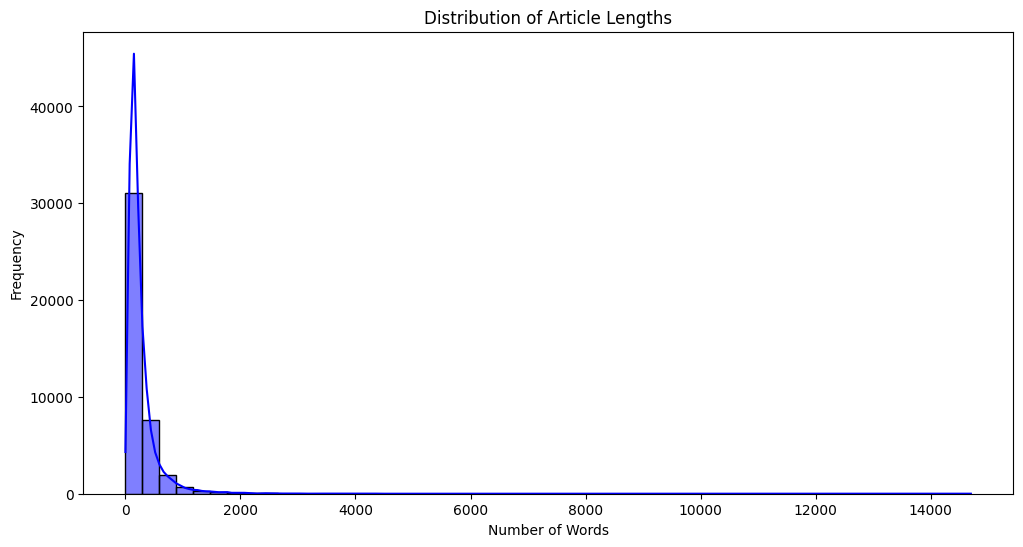

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate article lengths and add them as a column to df_filtered
df_filtered['Article_length'] = df_filtered['Article'].apply(lambda x: len(x.split()))

# Now you can create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(df_filtered['Article_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# **Skip-Gram + LSTM**

In [ ]:
sentences = [article.split() for article in df_filtered['Article']]
w2v_model = Word2Vec(sentences,
                     vector_size=EMBEDDING_DIM,
                     window=5,
                     min_count=1,
                     workers=multiprocessing.cpu_count(),
                     sg=1)
w2v_model.train(sentences, total_examples=len(sentences), epochs=10)
w2v_model.save("word2vec.model")

word_index = {t: i + 1 for i, t in enumerate(w2v_model.wv.index_to_key)}
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

print('Embedding matrix shape:', embedding_matrix.shape)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_filtered['Article'].values)
X_final = tokenizer.texts_to_sequences(df_filtered['Article'].values)
X_final = pad_sequences(X_final, maxlen=MAX_SEQUENCE_LENGTH)
Y_final = pd.get_dummies(df_filtered['label']).values

X_train, X_test, y_train, y_test = train_test_split(X_final, Y_final, test_size=0.33, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(Y_final.shape[1], activation='softmax'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Embedding matrix shape: (360907, 100)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 283s 394ms/step - accuracy: 0.5405 - loss: 1.2320 - val_accuracy: 0.7658 - val_loss: 0.7329
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 325s 398ms/step - accuracy: 0.7685 - loss: 0.7536 - val_accuracy: 0.8172 - val_loss: 0.5651
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 327s 405ms/step - accuracy: 0.8040 - loss: 0.6545 - val_accuracy: 0.8488 - val_loss: 0.5041
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 328s 414ms/step - accuracy: 0.8318 - loss: 0.5529 - val_accuracy: 0.8609 - val_loss: 0.4434
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 320s 411ms/step - accuracy: 0.8531 - loss: 0.4790 - val_accuracy: 0.8577 - val_loss: 0.4474
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 285s 405ms/step - accuracy: 0.8592 - loss: 0.4532 - val_accuracy: 0.8705 - val_loss: 0.4032
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 288s 409ms/step - accuracy: 0.8677 - loss: 0.4180 - val_accuracy: 0.8459 - val_loss: 0.4836
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 301s 380ms/step - accuracy: 0.8709 -

# **CBOW + LSTM**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

tokenized_texts = df_filtered['Article'].apply(lambda x: x.split()).tolist()

word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=multiprocessing.cpu_count(), sg=0)
word_vectors = word2vec_model.wv

embedding_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_filtered['Article'].astype(str).tolist())
for word, i in tokenizer.word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

texts = df_filtered['Article'].astype(str).tolist()
labels = df_filtered['label'].values

sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

y = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


840/840 ━━━━━━━━━━━━━━━━━━━━ 321s 372ms/step - accuracy: 0.7447 - loss: 0.7781 - val_accuracy: 0.8625 - val_loss: 0.4366
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 307s 365ms/step - accuracy: 0.8836 - loss: 0.3979 - val_accuracy: 0.8862 - val_loss: 0.3600
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 333s 378ms/step - accuracy: 0.8963 - loss: 0.3381 - val_accuracy: 0.9095 - val_loss: 0.2977
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 311s 365ms/step - accuracy: 0.9194 - loss: 0.2726 - val_accuracy: 0.8964 - val_loss: 0.3262
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 312s 371ms/step - accuracy: 0.9214 - loss: 0.2530 - val_accuracy: 0.9177 - val_loss: 0.2743
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 348s 415ms/step - accuracy: 0.9352 - loss: 0.2112 - val_accuracy: 0.9112 - val_loss: 0.2916
Epoch 7/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 322s 384ms/step - accuracy: 0.9421 - loss: 0.1836 - val_accuracy: 0.9137 - val_loss: 0.2977
Epoch 8/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 372s 372ms/step - accuracy: 0.9465 - loss: 0.16

# **FastText**

In [ ]:
!pip install gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from gensim.models import FastText

sentences = df_filtered['Article'].apply(lambda x: x.split()).tolist()

fasttext_model = FastText(sentences, vector_size=EMBEDDING_DIM, window=5, min_count=1, sg=1, epochs=10)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_filtered['Article'].astype(str).tolist())
word_index = tokenizer.word_index

embedding_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]

texts = df_filtered['Article'].astype(str).tolist()
labels = df_filtered['label'].values

sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

y = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Create the average FastText embeddings for each document
def get_average_embeddings(text, model, dim):
    words = text.split()
    feature_vec = np.zeros((dim,), dtype="float32")
    n_words = 0

    for word in words:
        if word in model.wv:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])

    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)

    return feature_vec

# Apply this to the entire dataset
X_embeddings = np.array([get_average_embeddings(text, fasttext_model, EMBEDDING_DIM) for text in df_filtered['Article'].astype(str).tolist()])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, labels, test_size=0.2, random_state=42)

# Train the Gaussian Naive Bayes model
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = gnb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.8551190476190477
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1248
           1       0.82      0.89      0.85      1204
           2       0.74      0.84      0.79      1187
           3       0.96      0.88      0.92      1236
           4       0.90      0.89      0.90      1120
           5       0.76      0.84      0.80      1201
           6       0.94      0.81      0.87      1204

    accuracy                           0.86      8400
   macro avg       0.86      0.86      0.86      8400
weighted avg       0.86      0.86      0.86      8400



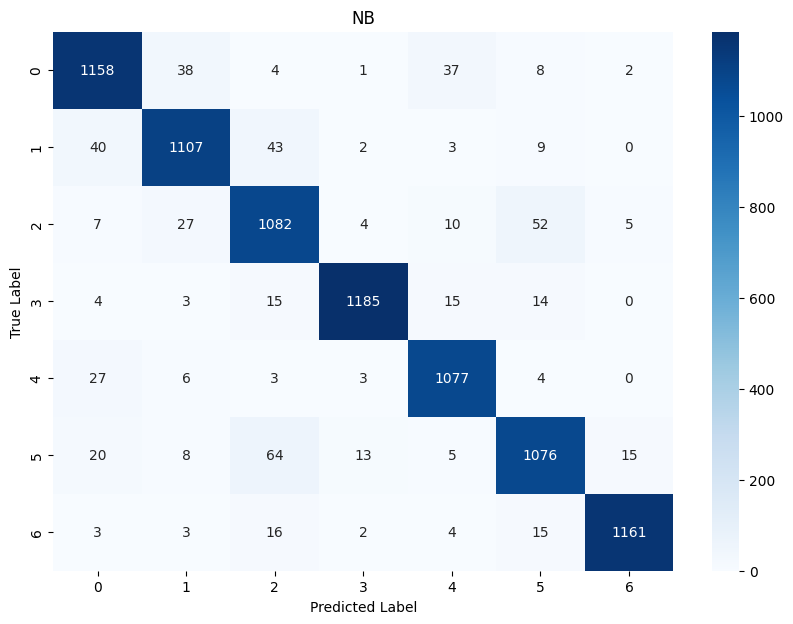

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('NB')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
def predict_text(text, model, fasttext_model, embedding_dim):

    embedding = get_average_embeddings(text, fasttext_model, embedding_dim).reshape(1, -1)
    prediction = model.predict(embedding)

    return prediction[0]

text = "يحيي كل من العروسي وعواطف وعمار والعنبري أمجاد الأغنية المغربية العصرية والكلاسيكية، في سهرة تنظم يوم 26 ماي المقبل، بمركب مولاي عبد الله"
# Predict the label, pass in the gnb_model here
predicted_label = predict_text(text, gnb_model, fasttext_model, EMBEDDING_DIM)

print(f"Predicted label: {predicted_label}")

Predicted label: 5


In [ ]:
def predict_text(text, model, fasttext_model, embedding_dim):

    embedding = get_average_embeddings(text, fasttext_model, embedding_dim).reshape(1, -1)
    prediction = model.predict(embedding)

    return prediction[0]

text = "الحمد لله، والصلاة والسلام على رسول الله، وآله وصحبه ومن والاه وبعد، فالموت في اللغة: ضد الحياة، يقال: مَاتَ يَمُوتُ فهو مَيْتٌ ومَيِّتٌ ضد حي"
# Predict the label, pass in the gnb_model here
predicted_label = predict_text(text, gnb_model, fasttext_model, EMBEDDING_DIM)

print(f"Predicted label: {predicted_label}")

Predicted label: 3


# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to compute the average FastText embedding for a given text
def get_average_embedding(text, model, embedding_dim):
    words = text.split()
    feature_vec = np.zeros((embedding_dim,), dtype="float32")
    n_words = 0

    for word in words:
        if word in model.wv:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])

    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)

    return feature_vec

# Convert the texts to FastText embeddings
X_embeddings = np.array([get_average_embedding(text, fasttext_model, EMBEDDING_DIM) for text in df_filtered['Article'].astype(str).tolist()])

# Split the data into training and test sets
X_train_embeddings, X_test_embeddings, y_train, y_test = train_test_split(X_embeddings, labels, test_size=0.2, random_state=42)

# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_embeddings, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.934047619047619
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1248
           1       0.93      0.92      0.92      1204
           2       0.88      0.91      0.90      1187
           3       0.98      0.96      0.97      1236
           4       0.94      0.96      0.95      1120
           5       0.91      0.90      0.90      1201
           6       0.98      0.96      0.97      1204

    accuracy                           0.93      8400
   macro avg       0.93      0.93      0.93      8400
weighted avg       0.93      0.93      0.93      8400



In [ ]:
def predict_text(text, model, fasttext_model, embedding_dim):

    embedding = get_average_embeddings(text, fasttext_model, embedding_dim).reshape(1, -1)
    prediction = model.predict(embedding)

    return prediction[0]

text = "يحيي كل من العروسي وعواطف وعمار والعنبري أمجاد الأغنية المغربية العصرية والكلاسيكية، في سهرة تنظم يوم 26 ماي المقبل، بمركب مولاي عبد الله"
# Predict the label, pass in the gnb_model here
predicted_label = predict_text(text,svm_model , fasttext_model, EMBEDDING_DIM)

print(f"Predicted label: {predicted_label}")

Predicted label: 5


In [ ]:
def predict_text(text, model, fasttext_model, embedding_dim):

    embedding = get_average_embeddings(text, fasttext_model, embedding_dim).reshape(1, -1)
    prediction = model.predict(embedding)

    return prediction[0]

text = "أبو فراس يدافع مجموعة من البرلمانيين عن حزب  الحاكم، باستماتة عن استمرار معاشات البرلمانيين، المثيرة للجدل"
# Predict the label, pass in the gnb_model here
predicted_label = predict_text(text,svm_model , fasttext_model, EMBEDDING_DIM)

print(f"Predicted label: {predicted_label}")

Predicted label: 2


# Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_embeddings, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9195238095238095
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1248
           1       0.91      0.91      0.91      1204
           2       0.85      0.90      0.87      1187
           3       0.98      0.94      0.96      1236
           4       0.93      0.96      0.95      1120
           5       0.87      0.89      0.88      1201
           6       0.98      0.92      0.95      1204

    accuracy                           0.92      8400
   macro avg       0.92      0.92      0.92      8400
weighted avg       0.92      0.92      0.92      8400



In [ ]:
def predict_text(text, model, fasttext_model, embedding_dim):

    embedding = get_average_embeddings(text, fasttext_model, embedding_dim).reshape(1, -1)
    prediction = model.predict(embedding)

    return prediction[0]

text = "يحيي كل من العروسي وعواطف وعمار والعنبري أمجاد الأغنية المغربية العصرية والكلاسيكية، في سهرة تنظم يوم 26 ماي المقبل، بمركب مولاي عبد الله"
# Predict the label, pass in the gnb_model here
predicted_label = predict_text(text,rf_model , fasttext_model, EMBEDDING_DIM)

print(f"Predicted label: {predicted_label}")

Predicted label: 5


In [ ]:
def predict_text(text, model, fasttext_model, embedding_dim):

    embedding = get_average_embeddings(text, fasttext_model, embedding_dim).reshape(1, -1)
    prediction = model.predict(embedding)

    return prediction[0]

text = "أعلن فيرناندو سانتوس، مدرب البرتغال، تشكيلته الرسمية لمباراة المغرب: حراسة المرمى: ريو باتريسيو. خط الدفاع: سيدريك سواريس"
# Predict the label, pass in the gnb_model here
predicted_label = predict_text(text,rf_model , fasttext_model, EMBEDDING_DIM)

print(f"Predicted label: {predicted_label}")

Predicted label: 6


# **RNN**

In [ ]:
# Define the RNN model
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 156s 182ms/step - accuracy: 0.4405 - loss: 1.4729 - val_accuracy: 0.6302 - val_loss: 1.0768
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 148s 176ms/step - accuracy: 0.5618 - loss: 1.2012 - val_accuracy: 0.5702 - val_loss: 1.1676
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 197s 170ms/step - accuracy: 0.6522 - loss: 1.0003 - val_accuracy: 0.5518 - val_loss: 1.2546
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 153s 182ms/step - accuracy: 0.6404 - loss: 1.0049 - val_accuracy: 0.5827 - val_loss: 1.0974
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.6260 - loss: 1.0753
Test Loss: 1.0792728662490845
Test Accuracy: 0.6253571510314941


In [ ]:
# Define prediction function
def predict_text(text, model, fasttext_model, embedding_dim, tokenizer, max_sequence_length):
    # Convert text to sequence
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

    # Predict
    prediction = model.predict(padded_sequences)

    # Get predicted class
    predicted_class = np.argmax(prediction, axis=-1)

    return predicted_class

# Example usage
text = "أعلن فيرناندو سانتوس، مدرب البرتغال، تشكيلته الرسمية لمباراة المغرب: حراسة المرمى: ريو باتريسيو. خط الدفاع: سيدريك سواريس"
predicted_label = predict_text(text, model, fasttext_model, EMBEDDING_DIM, tokenizer, MAX_SEQUENCE_LENGTH)

print(f"Predicted label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted label: [6]


# **CNN**

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 144s 163ms/step - accuracy: 0.7127 - loss: 0.7980 - val_accuracy: 0.9176 - val_loss: 0.2704
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 121s 139ms/step - accuracy: 0.9067 - loss: 0.3087 - val_accuracy: 0.9217 - val_loss: 0.2474
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 117s 140ms/step - accuracy: 0.9244 - loss: 0.2423 - val_accuracy: 0.9326 - val_loss: 0.2093
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 142s 140ms/step - accuracy: 0.9389 - loss: 0.1930 - val_accuracy: 0.9275 - val_loss: 0.2459
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 139s 136ms/step - accuracy: 0.9487 - loss: 0.1628 - val_accuracy: 0.9296 - val_loss: 0.2344
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 144s 140ms/step - accuracy: 0.9583 - loss: 0.1292 - val_accuracy: 0.9356 - val_loss: 0.2386
263/263 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9317 - loss: 0.2103
Test Loss: 0.2160913646221161
Test Accuracy: 0.932023823261261


In [ ]:
# Define prediction function
def predict_text(text, model, fasttext_model, embedding_dim, tokenizer, max_sequence_length):
    # Convert text to sequence
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

    # Predict
    prediction = model.predict(padded_sequences)

    # Get predicted class
    predicted_class = np.argmax(prediction, axis=-1)

    return predicted_class

# Example usage
text = "الحمد لله، والصلاة والسلام على رسول الله، وآله وصحبه ومن والاه وبعد، فالموت في اللغة: ضد الحياة، يقال: مَاتَ يَمُوتُ فهو مَيْتٌ ومَيِّتٌ ضد حي"
predicted_label = predict_text(text, model, fasttext_model, EMBEDDING_DIM, tokenizer, MAX_SEQUENCE_LENGTH)

print(f"Predicted label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted label: [3]


# **LSTM**

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 764s 905ms/step - accuracy: 0.6337 - loss: 1.0256 - val_accuracy: 0.1595 - val_loss: 1.9248
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 808s 911ms/step - accuracy: 0.4638 - loss: 1.3548 - val_accuracy: 0.8518 - val_loss: 0.4976
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 831s 946ms/step - accuracy: 0.8032 - loss: 0.6190 - val_accuracy: 0.8914 - val_loss: 0.3609
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 770s 908ms/step - accuracy: 0.8679 - loss: 0.4443 - val_accuracy: 0.8955 - val_loss: 0.3347
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 810s 917ms/step - accuracy: 0.8789 - loss: 0.4081 - val_accuracy: 0.9088 - val_loss: 0.2952
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 758s 903ms/step - accuracy: 0.9007 - loss: 0.3376 - val_accuracy: 0.9128 - val_loss: 0.2810
Epoch 7/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 771s 918ms/step - accuracy: 0.8990 - loss: 0.3468 - val_accuracy: 0.9103 - val_loss: 0.2867
Epoch 8/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 763s 909ms/step - accuracy: 0.9066 -

# **BI-LSTM**

In [ ]:
# Define the Bidirectional LSTM model
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1588s 2s/step - accuracy: 0.6635 - loss: 0.9718 - val_accuracy: 0.7893 - val_loss: 0.6250
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1570s 2s/step - accuracy: 0.8234 - loss: 0.5750 - val_accuracy: 0.8756 - val_loss: 0.4107
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1547s 2s/step - accuracy: 0.8591 - loss: 0.4582 - val_accuracy: 0.8994 - val_loss: 0.3274
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1547s 2s/step - accuracy: 0.8958 - loss: 0.3580 - val_accuracy: 0.9049 - val_loss: 0.3059
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1542s 2s/step - accuracy: 0.8913 - loss: 0.3565 - val_accuracy: 0.9076 - val_loss: 0.2835
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1611s 2s/step - accuracy: 0.9010 - loss: 0.3305 - val_accuracy: 0.9138 - val_loss: 0.2737
Epoch 7/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1561s 2s/step - accuracy: 0.9034 - loss: 0.3101 - val_accuracy: 0.9187 - val_loss: 0.2705
Epoch 8/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1614s 2s/step - accuracy: 0.9182 - loss: 0.2710 - 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Example input text
text = "هذا نص عربي للاختبار"

# Assume you have a word_index dictionary from training
# Replace this with your actual word_index used during training
word_index = {"هذا": 1, "نص": 2, "عربي": 3, "للاختبار": 4}  # Example word_index

# Convert the text to a sequence of word indices
sequence = [word_index.get(word, 0) for word in text.split()]  # Use 0 for unknown words

# Pad the sequence to match the input length expected by the model
padded_sequence = pad_sequences([sequence], maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Convert to numpy array
padded_sequence = np.array(padded_sequence)

# Make a prediction using the trained model
predictions = model.predict(padded_sequence)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=-1)

# Print the predicted label
print(f"Predicted label: {predicted_class[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: 3


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
!pip install --upgrade tensorflow
from huggingface_hub import push_to_hub_keras

model_name = "aya2003/my_bilstm_model"
push_to_hub_keras(model, model_name, plot_model=False)

saved_model.pb:   0%|          | 0.00/345k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/aya2003/my_bilstm_model/commit/93300263512f6912ea640ab6328083715426b340', commit_message='Push Keras model using huggingface_hub.', commit_description='', oid='93300263512f6912ea640ab6328083715426b340', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from huggingface_hub import from_pretrained_keras

model_name = "aya2003/my_bilstm_model"
loaded_model = from_pretrained_keras(model_name)


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/345k [00:00<?, ?B/s]

In [ ]:
from huggingface_hub import from_pretrained_keras

def load_model(model_name):
    try:
        loaded_model = from_pretrained_keras(model_name)
        print(f"Model '{model_name}' loaded successfully!")
        return loaded_model
    except Exception as e:
        print(f"Failed to load model: {str(e)}")
        return None

if __name__ == "__main__":
    model_name = input("Enter the model name: ")
    load_model(model_name)



Enter the model name: aya2003/my_bilstm_model


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Model 'aya2003/my_bilstm_model' loaded successfully!


In [ ]:
!pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display
from huggingface_hub import from_pretrained_keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the pre-trained model (same as before)
def load_model(model_name):
    try:
        global loaded_model
        loaded_model = from_pretrained_keras(model_name)
        print(f"Model '{model_name}' loaded successfully!")
    except Exception as e:
        print(f"Failed to load model: {str(e)}")

# Process the text and make predictions (modified for ipywidgets)
def predict_label(sender):
    text = text_input.value

    # Replace this with your actual word_index used during training
    word_index = {"هذا": 1, "نص": 2, "عربي": 3, "للاختبار": 4}  # Example word_index
    sequence = [word_index.get(word, 0) for word in text.split()]  # Use 0 for unknown words

    # Pad the sequence to match the input length expected by the model
    padded_sequence = pad_sequences([sequence], maxlen=100, padding='post') # Replace 100 with actual MAX_SEQUENCE_LENGTH
    padded_sequence = np.array(padded_sequence)

    # Make predictions
    try:
        predictions = loaded_model.predict(padded_sequence)
        predicted_class = np.argmax(predictions, axis=-1)
        print(f"Predicted label: {predicted_class[0]}")
    except Exception as e:
        print(f"Prediction failed: {str(e)}")

# Widgets for interaction
model_name_input = widgets.Text(value="aya2003/my_bilstm_model", description="Model Name:")
load_button = widgets.Button(description="Load Model")
text_input = widgets.Textarea(description="Enter Text:")
predict_button = widgets.Button(description="Predict")

# Event handlers
load_button.on_click(lambda b: load_model(model_name_input.value))
predict_button.on_click(predict_label)

# Display widgets
display(model_name_input, load_button)
display(text_input, predict_button)

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


Text(value='aya2003/my_bilstm_model', description='Model Name:')

Button(description='Load Model', style=ButtonStyle())

Textarea(value='', description='Enter Text:')

Button(description='Predict', style=ButtonStyle())

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Model 'aya2003/my_bilstm_model' loaded successfully!
Prediction failed: '_UserObject' object has no attribute 'predict'


# Another save

In [ ]:
# Save the model to a file
model.save("bilstm_model.h5")


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("bilstm_model.h5")
predictions = loaded_model.predict(X_test)

263/263 ━━━━━━━━━━━━━━━━━━━━ 140s 529ms/step


# **GRU**

In [ ]:
# Define the GRU model
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(GRU(128, return_sequences=True))
model.add(GRU(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(Y_final.shape[1], activation='softmax'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 520s 606ms/step - accuracy: 0.6983 - loss: 0.8403 - val_accuracy: 0.9122 - val_loss: 0.2784
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 527s 566ms/step - accuracy: 0.9092 - loss: 0.2944 - val_accuracy: 0.9310 - val_loss: 0.2172
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 502s 566ms/step - accuracy: 0.9282 - loss: 0.2428 - val_accuracy: 0.9365 - val_loss: 0.1993
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 502s 567ms/step - accuracy: 0.9331 - loss: 0.2209 - val_accuracy: 0.9399 - val_loss: 0.1880
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 500s 565ms/step - accuracy: 0.9382 - loss: 0.1970 - val_accuracy: 0.9400 - val_loss: 0.1905
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 478s 569ms/step - accuracy: 0.9437 - loss: 0.1762 - val_accuracy: 0.9429 - val_loss: 0.1854
Epoch 7/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 501s 568ms/step - accuracy: 0.9476 - loss: 0.1594 - val_accuracy: 0.9470 - val_loss: 0.1701
Epoch 8/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 503s 568ms/step - accuracy: 0.9596 -

# **BI-GRU**

In [ ]:
# Define the GRU model
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Bidirectional(GRU(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1541s 2s/step - accuracy: 0.7148 - loss: 0.7994 - val_accuracy: 0.9155 - val_loss: 0.2703
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1488s 2s/step - accuracy: 0.9175 - loss: 0.2738 - val_accuracy: 0.9274 - val_loss: 0.2248
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1484s 2s/step - accuracy: 0.9311 - loss: 0.2262 - val_accuracy: 0.9412 - val_loss: 0.1853
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1468s 2s/step - accuracy: 0.9403 - loss: 0.1973 - val_accuracy: 0.9384 - val_loss: 0.1978
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1516s 2s/step - accuracy: 0.9466 - loss: 0.1748 - val_accuracy: 0.9375 - val_loss: 0.1895
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 1610s 2s/step - accuracy: 0.9546 - loss: 0.1323 - val_accuracy: 0.9348 - val_loss: 0.2231
263/263 ━━━━━━━━━━━━━━━━━━━━ 109s 413ms/step - accuracy: 0.9367 - loss: 0.1851
Test Loss: 0.19409875571727753
Test Accuracy: 0.9358333349227905


In [ ]:
import pandas as pd

#Define the number of samples you want per label
samples_per_label = 1000

#Group by label and randomly sample samples_per_label rows for each label
df_filtered = df.groupby('label').apply(lambda x: x.sample(n=samples_per_label, random_state=None)).reset_index(drop=True)

#Display the count of each label in the filtered DataFrame
print(df_filtered['label'].value_counts())

#Display the first few rows of the filtered DataFrame
df_filtered.head()

label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
Name: count, dtype: int64


,Article,label
0,رشا صفوت يعتبر معدل استهلاك الغسالات الاتوماتي...,0
1,اعلنت شركه سانديسك امس عن طرح نسخه محدثه من بر...,0
2,سامسونج تستعرض شاشتها المرنه علي هاتف تجريبي ا...,0
3,صمم غطاء فريد من نوعه يحول الهاتف الذكي الي كا...,0
4,تم اطلاق الاصدار الجديد السريع والمميز من مستع...,0


# ***`Transformers`***

In [ ]:
# @title BaseLineBert
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Use the BERT base cased model identifier
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)  # Adjust max_length as needed

# Assuming df_filtered is a DataFrame with 'Article' and 'label' columns
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(df_filtered['label'].unique()))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # evaluate at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_datasets['train'],         # training dataset
    eval_dataset=tokenized_datasets['validation'],     # evaluation dataset
    compute_metrics=compute_metrics,     # function to compute metrics
)

# Train the model
trainer.train()


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.179800,1.206868,0.528571,0.512875,0.617783,0.528571
2,0.867700,0.728229,0.764286,0.761319,0.785706,0.764286
3,0.435000,0.574921,0.815714,0.814938,0.814551,0.815714


TrainOutput(global_step=1182, training_loss=1.054359729923371, metrics={'train_runtime': 23476.1498, 'train_samples_per_second': 0.805, 'train_steps_per_second': 0.05, 'total_flos': 1243255547520000.0, 'train_loss': 1.054359729923371, 'epoch': 3.0})

In [ ]:
!pip install transformers datasets
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model.push_to_hub("shahendaadel211/bert-model")
tokenizer.push_to_hub("shahendaadel211/bert-model")

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shahendaadel211/bert-model/commit/2dcedc72ddbf89971c5651b2c0ea465979671380', commit_message='Upload tokenizer', commit_description='', oid='2dcedc72ddbf89971c5651b2c0ea465979671380', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the model and tokenizer from the Hugging Face Hub
model_name = "shahendaadel211/bert-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Assuming `df_filtered` is your original DataFrame
# Encode the labels to be integers starting from 0
label_encoder = LabelEncoder()
df_filtered['label'] = label_encoder.fit_transform(df_filtered['label'])

# Get the number of unique labels
num_labels = len(df_filtered['label'].unique())

# Initialize the model with the correct number of labels
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})


def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,  # Batch size for evaluation
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_datasets['validation']
)

predictions = trainer.predict(tokenized_datasets['validation'])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

conf_matrix = confusion_matrix(labels, preds)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(labels, preds))

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Confusion Matrix:
[[80  6  2  2  7  3  0]
 [ 5 73 16  0  2  1  3]
 [ 0  5 80  2  0  9  4]
 [ 0  1  3 87  4  3  2]
 [ 4  3  1  3 85  2  2]
 [ 1  5 10  2  2 78  2]
 [ 1  0  0  2  0  2 95]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       100
           1       0.78      0.73      0.76       100
           2       0.71      0.80      0.75       100
           3       0.89      0.87      0.88       100
           4       0.85      0.85      0.85       100
           5       0.80      0.78      0.79       100
           6       0.88      0.95      0.91       100

    accuracy                           0.83       700
   macro avg       0.83      0.83      0.83       700
weighted avg       0.83      0.83      0.83       700



# **RoBERTa**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Use the RoBERTa model identifier
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)

# Assuming df_filtered is already defined and preprocessed
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(df_filtered['label'].unique()))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # evaluate at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_datasets['train'],         # training dataset
    eval_dataset=tokenized_datasets['validation'],     # evaluation dataset
    compute_metrics=compute_metrics,     # function to compute metrics
)

# Train the model
trainer.train()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.716500,1.637158,0.364286,0.304319,0.368003,0.364286
2,1.213600,1.158586,0.568571,0.547410,0.574841,0.568571
3,0.848800,1.003361,0.641429,0.632415,0.639512,0.641429


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1182, training_loss=1.4027636426354422, metrics={'train_runtime': 23785.7323, 'train_samples_per_second': 0.795, 'train_steps_per_second': 0.05, 'total_flos': 1243255547520000.0, 'train_loss': 1.4027636426354422, 'epoch': 3.0})

In [ ]:
!pip install transformers datasets
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Define your model and tokenizer variables
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)  # Adjust num_labels as needed
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Push model and tokenizer to Hugging Face Hub
model.push_to_hub("abdulrahman4111/roberta22-model")
tokenizer.push_to_hub("abdulrahman4111/roberta22-model")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/abdulrahman4111/roberta-model/commit/8dd7ee5fc9e64ceed5497cb2c1748fef01710a85', commit_message='Upload tokenizer', commit_description='', oid='8dd7ee5fc9e64ceed5497cb2c1748fef01710a85', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Load the model and tokenizer from the Hugging Face Hub
model_name = "abdulrahman4111/roberta22-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Assuming `df_filtered` is your original DataFrame
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,  # Batch size for evaluation
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_datasets['validation']
)

# Get predictions
predictions = trainer.predict(tokenized_datasets['validation'])

# Get the predicted labels and true labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optional: You can also print a classification report for additional metrics
print("Classification Report:")
print(classification_report(labels, preds))


tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Confusion Matrix:
[[  0   0   0   0   0 100   0]
 [  0   0   0   0   0 100   0]
 [  0   0   0   0   0 100   0]
 [  0   0   0   0   0 100   0]
 [  0   0   0   0   0 100   0]
 [  0   0   0   0   0 100   0]
 [  0   0   0   0   0 100   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.14      1.00      0.25       100
           6       0.00      0.00      0.00       100

    accuracy                           0.14       700
   macro avg       0.02      0.14      0.04       700
weighted avg       0.02      0.14      0.04       700



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **DistilBERT**

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define the number of samples you want per label
samples_per_label = 1000

# Group by label and randomly sample samples_per_label rows for each label
df_filtered = df.groupby('label').apply(lambda x: x.sample(n=samples_per_label, random_state=42)).reset_index(drop=True)

# Display the count of each label in the filtered DataFrame
print(df_filtered['label'].value_counts())

# Display the first few rows of the filtered DataFrame
print(df_filtered.head())

# Model and tokenizer setup
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)

# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(df_filtered['label'].unique()))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # evaluate at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_datasets['train'],         # training dataset
    eval_dataset=tokenized_datasets['validation'],     # evaluation dataset
    compute_metrics=compute_metrics,     # function to compute metrics
)

# Train the model
trainer.train()


label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
Name: count, dtype: int64
                                             Article  label
0  يملك هاتفا ابل الجديدين اي فون و بلس ميزه تتعل...      0
1  قال مصدر مسءول في هيءه تنظيم الاتصالات لالخليج...      0
2  دبي « الخليج » تشارك محاكم دبي في اسبوع « جيتك...      0
3  اطلق موقع فيس بوك ميزه جديده تتيح للمستخدمين ا...      0
4  قرر العملاق الالكتروني الكوري الجنوبي سامسونغ ...      0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.425200,1.376921,0.510000,0.486314,0.553058,0.510000
2,0.911200,0.924874,0.677143,0.681427,0.693280,0.677143
3,0.554700,0.779104,0.730000,0.729026,0.729483,0.730000


TrainOutput(global_step=1182, training_loss=1.204840311342488, metrics={'train_runtime': 13771.2163, 'train_samples_per_second': 1.372, 'train_steps_per_second': 0.086, 'total_flos': 625964269593600.0, 'train_loss': 1.204840311342488, 'epoch': 3.0})

In [ ]:
!pip install transformers datasets
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Push model and tokenizer to Hugging Face Hub
model.push_to_hub("abdulrahman4111/distilbert212-model")
tokenizer.push_to_hub("abdulrahman4111/distilbert212-model")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/abdulrahman4111/distilbert212-model/commit/8c529ccf20df796ba7a710f165c0c380753d8713', commit_message='Upload tokenizer', commit_description='', oid='8c529ccf20df796ba7a710f165c0c380753d8713', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Load the model and tokenizer from the Hugging Face Hub
model_name = "abdulrahman4111/distilbert212-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Assuming `df_filtered` is your original DataFrame
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,  # Batch size for evaluation
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_datasets['validation']
)

# Get predictions
predictions = trainer.predict(tokenized_datasets['validation'])

# Get the predicted labels and true labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optional: You can also print a classification report for additional metrics
print("Classification Report:")
print(classification_report(labels, preds))


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Confusion Matrix:
[[75  8  5  1 10  0  1]
 [ 7 59 22  0  5  4  3]
 [ 0 11 69  3  6  9  2]
 [ 2  2  3 87  5  0  1]
 [ 6  3  3  8 79  0  1]
 [ 2  6 12  3  1 74  2]
 [ 0  0  1  0  0  3 96]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       100
           1       0.66      0.59      0.62       100
           2       0.60      0.69      0.64       100
           3       0.85      0.87      0.86       100
           4       0.75      0.79      0.77       100
           5       0.82      0.74      0.78       100
           6       0.91      0.96      0.93       100

    accuracy                           0.77       700
   macro avg       0.77      0.77      0.77       700
weighted avg       0.77      0.77      0.77       700



# AraElectra

In [ ]:
!pip install transformers datasets


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import json
import os

# Load the model and tokenizer from the Hugging Face Hub
model_name = "aya2003/araelectra-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define the function to tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)

# Assuming df_filtered is already defined and preprocessed
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the training arguments (adjust logging_dir to your setup)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,                # Log every 10 steps
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch"            # Save model checkpoints at the end of each epoch
)

# Initialize the Trainer with the model, tokenizer, and training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_datasets['validation']
)

# Evaluate the model on the validation dataset
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Retrieve epoch-wise results from logs
log_dir = './logs'
epochs = []
accuracies = []
f1_scores = []

# Iterate through log files
for file_name in os.listdir(log_dir):
    if file_name.endswith('.json'):
        with open(os.path.join(log_dir, file_name)) as f:
            log_data = json.load(f)
            epoch = log_data.get('epoch')
            if epoch is not None:
                epochs.append(epoch)
                accuracies.append(log_data.get('eval_accuracy', 'N/A'))
                f1_scores.append(log_data.get('eval_f1', 'N/A'))

# Print the results
for epoch, accuracy, f1 in zip(epochs, accuracies, f1_scores):
    print(f"Epoch {epoch} - Accuracy: {accuracy}, F1 Score: {f1}")


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Evaluation results: {'eval_loss': 0.26629891991615295, 'eval_runtime': 265.4236, 'eval_samples_per_second': 2.637, 'eval_steps_per_second': 0.166}


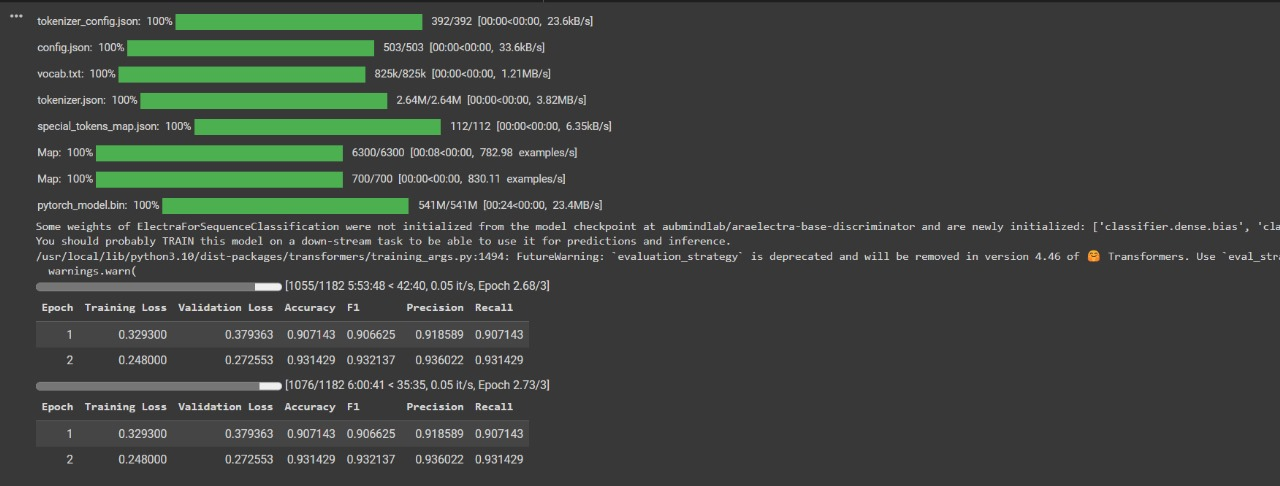

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Load the model and tokenizer from the Hugging Face Hub
model_name = "aya2003/araelectra-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Assuming `df_filtered` is your original DataFrame
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,  # Batch size for evaluation
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_datasets['validation']
)

# Get predictions
predictions = trainer.predict(tokenized_datasets['validation'])

# Get the predicted labels and true labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optional: You can also print a classification report for additional metrics
print("Classification Report:")
print(classification_report(labels, preds))


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Confusion Matrix:
[[94  2  0  0  2  2  0]
 [ 2 91  6  0  1  0  0]
 [ 1  5 88  0  1  4  1]
 [ 0  0  1 97  1  1  0]
 [ 1  0  0  1 98  0  0]
 [ 0  2  2  1  0 92  3]
 [ 0  2  0  0  0  0 98]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       100
           1       0.89      0.91      0.90       100
           2       0.91      0.88      0.89       100
           3       0.98      0.97      0.97       100
           4       0.95      0.98      0.97       100
           5       0.93      0.92      0.92       100
           6       0.96      0.98      0.97       100

    accuracy                           0.94       700
   macro avg       0.94      0.94      0.94       700
weighted avg       0.94      0.94      0.94       700



In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:

# Push model and tokenizer to Hugging Face Hub
model.push_to_hub("aya2003/araelectra-model")
tokenizer.push_to_hub("aya2003/araelectra-model")



model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aya2003/araelectra-model/commit/16a3be6d91c0f6617df4052e60581ce5d884f02f', commit_message='Upload tokenizer', commit_description='', oid='16a3be6d91c0f6617df4052e60581ce5d884f02f', pr_url=None, pr_revision=None, pr_num=None)

# **AraBERT**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Use a valid Arabic BERT model identifier
model_name = 'aubmindlab/bert-base-arabertv2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)  # Adjust max_length as needed

# Assuming df_filtered is already defined and preprocessed
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(df_filtered['label'].unique()))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # evaluate at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_datasets['train'],         # training dataset
    eval_dataset=tokenized_datasets['validation'],     # evaluation dataset
    compute_metrics=compute_metrics,     # function to compute metrics
)

# Train the model
trainer.train()


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.453700,0.361440,0.902857,0.902179,0.916934,0.902857
2,0.375100,0.274595,0.932857,0.932849,0.934618,0.932857
3,0.245900,0.237062,0.945714,0.945724,0.946714,0.945714


TrainOutput(global_step=1182, training_loss=0.4180193511822754, metrics={'train_runtime': 26576.5757, 'train_samples_per_second': 0.711, 'train_steps_per_second': 0.044, 'total_flos': 1243255547520000.0, 'train_loss': 0.4180193511822754, 'epoch': 3.0})

In [ ]:
# Push model and tokenizer to Hugging Face Hub
model.push_to_hub("shahendaadel211/arabertv2-model")
tokenizer.push_to_hub("shahendaadel211/arabertv2-model")

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shahendaadel211/arabertv2-model/commit/a3ddf4b6400413013131cd027e48f932fc3e9780', commit_message='Upload tokenizer', commit_description='', oid='a3ddf4b6400413013131cd027e48f932fc3e9780', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Load the model and tokenizer from the Hugging Face Hub
model_name = "shahendaadel211/arabertv2-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Assuming `df_filtered` is your original DataFrame
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,  # Batch size for evaluation
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_datasets['validation']
)

# Get predictions
predictions = trainer.predict(tokenized_datasets['validation'])

# Get the predicted labels and true labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optional: You can also print a classification report for additional metrics
print("Classification Report:")
print(classification_report(labels, preds))


tokenizer_config.json:   0%|          | 0.00/6.79k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/656k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Confusion Matrix:
[[ 93   3   0   0   3   0   1]
 [  2  92   4   0   0   1   1]
 [  0   3  93   1   0   1   2]
 [  0   0   1  96   3   0   0]
 [  0   1   0   0  99   0   0]
 [  0   3   4   1   0  92   0]
 [  0   0   0   0   0   0 100]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       100
           1       0.90      0.92      0.91       100
           2       0.91      0.93      0.92       100
           3       0.98      0.96      0.97       100
           4       0.94      0.99      0.97       100
           5       0.98      0.92      0.95       100
           6       0.96      1.00      0.98       100

    accuracy                           0.95       700
   macro avg       0.95      0.95      0.95       700
weighted avg       0.95      0.95      0.95       700



# MaraBert 2

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Use a valid MARABERT model identifier
model_name = 'UBC-NLP/MARBERT'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)  # Adjust max_length as needed

# Assuming df_filtered is already defined and preprocessed
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(df_filtered['label'].unique()))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # evaluate at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_datasets['train'],         # training dataset
    eval_dataset=tokenized_datasets['validation'],     # evaluation dataset
    compute_metrics=compute_metrics,     # function to compute metrics
)

# Train the model
trainer.train()


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.282900,0.424430,0.895714,0.894213,0.911549,0.895714
2,0.172500,0.316518,0.928571,0.928525,0.930741,0.928571
3,0.110300,0.289157,0.941429,0.941540,0.942433,0.941429


TrainOutput(global_step=1182, training_loss=0.34814718713930315, metrics={'train_runtime': 27779.1727, 'train_samples_per_second': 0.68, 'train_steps_per_second': 0.043, 'total_flos': 1243255547520000.0, 'train_loss': 0.34814718713930315, 'epoch': 3.0})

In [ ]:
!pip install transformers datasets
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model.push_to_hub("aya2003/marabert22-model")
tokenizer.push_to_hub("aya2003/marabert22-model")

model.safetensors:   0%|          | 0.00/651M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aya2003/marabert22-model/commit/3c79a8c28ce1a378a02b69a3122472ed29176662', commit_message='Upload tokenizer', commit_description='', oid='3c79a8c28ce1a378a02b69a3122472ed29176662', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Load the model and tokenizer from the Hugging Face Hub
model_name = "aya2003/marabert22-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Assuming `df_filtered` is your original DataFrame
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,  # Batch size for evaluation
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_datasets['validation']
)

# Get predictions
predictions = trainer.predict(tokenized_datasets['validation'])

# Get the predicted labels and true labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optional: You can also print a classification report for additional metrics
print("Classification Report:")
print(classification_report(labels, preds))


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/651M [00:00<?, ?B/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Confusion Matrix:
[[96  1  0  0  2  1  0]
 [ 3 93  2  0  0  1  1]
 [ 0  5 89  1  1  3  1]
 [ 0  0  2 96  1  1  0]
 [ 3  1  0  0 96  0  0]
 [ 0  4  1  1  0 93  1]
 [ 1  0  0  0  0  1 98]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       100
           1       0.89      0.93      0.91       100
           2       0.95      0.89      0.92       100
           3       0.98      0.96      0.97       100
           4       0.96      0.96      0.96       100
           5       0.93      0.93      0.93       100
           6       0.97      0.98      0.98       100

    accuracy                           0.94       700
   macro avg       0.94      0.94      0.94       700
weighted avg       0.94      0.94      0.94       700



# **bert-mini**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Use a valid Arabic DistilBERT model identifier
model_name = 'asafaya/bert-mini-arabic'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)  # Adjust max_length as needed

# Assuming df_filtered is already defined and preprocessed
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(df_filtered['label'].unique()))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # evaluate at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_datasets['train'],         # training dataset
    eval_dataset=tokenized_datasets['validation'],     # evaluation dataset
    compute_metrics=compute_metrics,     # function to compute metrics
)

# Train the model
trainer.train()




tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/509 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/46.6M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-mini-arabic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.505200,0.492671,0.911429,0.911519,0.913572,0.911429
2,0.261100,0.280532,0.917143,0.917005,0.919249,0.917143
3,0.125700,0.260642,0.927143,0.926858,0.929532,0.927143


TrainOutput(global_step=1182, training_loss=0.5950348967222998, metrics={'train_runtime': 1385.661, 'train_samples_per_second': 13.64, 'train_steps_per_second': 0.853, 'total_flos': 46842626073600.0, 'train_loss': 0.5950348967222998, 'epoch': 3.0})

In [ ]:
# Push model and tokenizer to Hugging Face Hub
model.push_to_hub("shahendaadel211/arabic-distilbert-model")
tokenizer.push_to_hub("shahendaadel211/arabic-distilbert-model")

model.safetensors:   0%|          | 0.00/46.2M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shahendaadel211/arabic-distilbert-model/commit/f53212f310c11e4fab9bdfade551b12fe469a393', commit_message='Upload tokenizer', commit_description='', oid='f53212f310c11e4fab9bdfade551b12fe469a393', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Load the model and tokenizer from the Hugging Face Hub
model_name = "shahendaadel211/arabic-distilbert-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Assuming `df_filtered` is your original DataFrame
# Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered['label'], random_state=42)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['Article', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Article', 'label']])

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['Article'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,  # Batch size for evaluation
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_datasets['validation']
)

# Get predictions
predictions = trainer.predict(tokenized_datasets['validation'])

# Get the predicted labels and true labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optional: You can also print a classification report for additional metrics
print("Classification Report:")
print(classification_report(labels, preds))


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/838k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.2M [00:00<?, ?B/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Confusion Matrix:
[[ 88   6   0   0   5   1   0]
 [  3  91   3   1   0   1   1]
 [  0   2  94   1   2   1   0]
 [  1   0   2  96   1   0   0]
 [  2   0   0   0  98   0   0]
 [  2   6   2   2   0  88   0]
 [  0   0   0   0   0   0 100]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       100
           1       0.87      0.91      0.89       100
           2       0.93      0.94      0.94       100
           3       0.96      0.96      0.96       100
           4       0.92      0.98      0.95       100
           5       0.97      0.88      0.92       100
           6       0.99      1.00      1.00       100

    accuracy                           0.94       700
   macro avg       0.94      0.94      0.94       700
weighted avg       0.94      0.94      0.94       700

